# Save

In [81]:
import dill
dill.dump_session('notebook_env.db')

ValueError: ctypes objects containing pointers cannot be pickled

# Load

In [1]:
import dill
dill.load_session('notebook_env.db')

In [3]:
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from hyperopt import fmin, hp, tpe, Trials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import copy
import time
import datetime

In [5]:
data = pd.read_csv("Diabetes study file cleaned.csv", header = "infer")
data7 = pd.read_csv("Diabetes Study File 10K Dec 7 2017 Flattened.csv", header = "infer")
data14 = pd.read_csv("Diabetes Study File 10K Dec 14 2017 Flattened.csv", header = "infer")

data = data7.append(data14).drop_duplicates()
data = data[(data["FBS>DM"]==0)|(data["DIABETES"]=="No")]

#Creating a dummy variable for sex
data ["Sex"] = data["Sex"] == "Male"
data ["DIABETES"] = data ["DIABETES"] == "Yes"
data ["HDL"] = data["Total_Cholesterol"]-data["LDL"]-data["TG"]/5
data ["Corticosteroids"] = data ["Corticosteroids"].notnull()
data = data.drop (["Hypertension_Medications", "FBS>DM"], axis = 1)

data = data.reset_index(drop = True)
print (data)

       Age_at_Exam    sBP        BMI   LDL       HDL       A1c    TG  FBS  \
0               65  126.0  31.000000  1.66  1.694000  5.400000  2.28  5.8   
1               62  135.0  25.846483  2.49  1.716000  5.800000  1.37  5.4   
2               63  133.0  30.900000  1.65       NaN  6.100000  0.76  5.6   
3               51  136.0  56.710775  2.80  2.192000  6.000000  0.99  6.0   
4               40  123.0  33.067867  2.48  1.432000  5.800000  1.04  5.2   
5               60  130.0  67.751227  2.20  1.578000  6.100000  0.76  5.4   
6               41  129.0  37.471938  2.60  1.220000  5.500000  0.80  4.7   
7               70  150.0  25.500000  2.05  1.352000  5.800000  1.04  5.4   
8               70  123.0  33.000000  2.08  1.844000  5.400000  1.13  5.4   
9               54  104.0  25.333598  3.07  1.844000  5.600000  1.63  5.1   
10              39  156.0  33.591626  3.13  1.708000  6.300000  1.71  4.5   
11              67  147.0  28.000000  5.03  1.678000  5.800001  1.46  5.3   

# Handlin Missing Data

In [6]:
print (data.isnull().sum())

Age_at_Exam                  0
sBP                         10
BMI                          0
LDL                         34
HDL                        380
A1c                          0
TG                          88
FBS                          0
Total_Cholesterol          279
Depression                   0
HTN                          0
OA                           0
COPD                         0
Corticosteroids              0
Sex                          0
Ace Inhibitor                0
Alpha Blocker                0
ARB                          0
Beta Blocker                 0
Calcium Channel Blocker      0
Diuretic                     0
Other                        0
DIABETES                     0
dtype: int64


In [7]:
data = data.fillna(data.mean())

# Outlier detection using LOF

In [8]:
lof = LocalOutlierFactor (n_neighbors = 1, contamination = 0.05, metric = "manhattan")
outliers = lof.fit_predict(data.loc[:,data.columns != "DIABETES"])

outlierDF = pd.DataFrame(outliers)
data = data[outlierDF[0]==1]
print (data.shape)

(10525, 23)


# Check for zero-variance

In [9]:
varianceDF = pd.DataFrame(columns = ["Feature", "Percent_unique", "Freq_Ratio"])
for i in data:
    value, count = np.unique(data[i], return_counts = True)
    count = np.flip(np.sort(count), axis = 0)
    tempDF = pd.DataFrame(columns = ["Feature", "Percent_unique", "Freq_Ratio"])
    tempDF.loc[0] = [i, len(value)/len(data[i])*100.0, count[0]/count[1]]
    varianceDF = varianceDF.append(tempDF)
    
print (varianceDF)
# get rid fo all with FBS > DM of 1

                   Feature  Percent_unique  Freq_Ratio
0              Age_at_Exam        0.693587    1.016779
0                      sBP        1.178147    1.102394
0                      BMI       31.173397    1.014706
0                      LDL        6.223278    1.060976
0                      HDL       38.042755   22.625000
0                      A1c        1.035629    1.008145
0                       TG        5.710214    1.010000
0                      FBS        1.206651    1.068389
0        Total_Cholesterol        7.230404    3.777778
0               Depression        0.019002    3.648852
0                      HTN        0.019002    1.324939
0                       OA        0.019002    2.419428
0                     COPD        0.019002   10.317204
0          Corticosteroids        0.019002    2.657054
0                      Sex        0.019002    1.290533
0            Ace Inhibitor        0.019002    2.093768
0            Alpha Blocker        0.019002  205.372549
0         

# Dropping zero-variance features

In [10]:
#Features dropped for having too high of a frequency ratio between first and second most common items
data = data.drop(["HDL","COPD","Alpha Blocker","Other"], axis = 1)

In [11]:
corr_matrix = data.corr().abs()

correlated_featres = []
for column in corr_matrix:
    tempList = corr_matrix.index[corr_matrix[column] > 0.8].tolist()
    if (len(tempList)>1 and tempList not in correlated_featres):
        correlated_featres.append(tempList)
print ("Highly correlated features:", correlated_featres)

Highly correlated features: [['LDL', 'Total_Cholesterol']]


In [12]:
#Dropping Total_Cholesterol because it is the total of HDL, LDL, and TG/5, however HDL and TG are not highly correlated features
data = data.drop (["Total_Cholesterol"], axis = 1)

In [13]:
linear_combo = np.linalg.qr(data)[1]
linear_combo = linear_combo.sum(axis = 1)

bad_features = []

for i in range(len(data.columns.values)):
    if abs(linear_combo[i]) < 1.e-10:
        bad_features.append(data.columns.values[i])

print("Linearly correlated features:", bad_features)

Linearly correlated features: []


# Normalize data between 0 and 1

In [14]:
data_values = data.values
dataColumm = data.columns.values
min_max_scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data_values), columns = dataColumm)

C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Imbalanced dataset

In [15]:
print (data["DIABETES"].value_counts())

0.0    9165
1.0    1360
Name: DIABETES, dtype: int64


# Split data into testing and training sets and applying SMOTE

In [16]:
X = data.loc[:,data.columns != "DIABETES"]
Y = data["DIABETES"]

X_train, X_test, y_train, y_test = train_test_split (X,Y,test_size = 0.3)

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
X_train_sm = pd.DataFrame(X_train_sm, columns = X_train.columns)
y_train_sm = pd.DataFrame(y_train_sm)
y_train_sm.columns = ["DIABETES"]

dTrain = xgb.DMatrix(X_train_sm, y_train_sm)
dTest = xgb.DMatrix(X_test, y_test)

In [30]:
tpe_trials = Trials()
tpe_algo = tpe.suggest

run_counter = 0

In [31]:
def XgbHyperoptLoss (params):
    params["n_estimators"] = round(params["n_estimators"])
    params["max_depth"] = round(params["max_depth"])

    model = xgb.XGBClassifier(**params)
    
    score = cross_validate(estimator= model, X = X_train_sm, y = y_train_sm.values.ravel(), cv = 10)
    
    out = np.mean(score["test_score"])
    
    global run_counter, start_time, hyperopt_iterations
    run_counter += 1
    time_elapsed = time.time()-start_time
    print ("running iteration:",run_counter,
           "|time elapsed:", datetime.timedelta(seconds = round(time_elapsed)),
           "|estimated completion time:", time.ctime(time_elapsed/float(run_counter)*hyperopt_iterations+start_time),
           end = "\r")
    
    return 1-out

def XgbHyperopt (iterations, params):
    global run_counter
    run_counter += 1

    tpe_best = fmin(fn = XgbHyperoptLoss, space = params, algo = tpe_algo, trials= tpe_trials, max_evals = iterations)

    print ("XGBoost")

    print (tpe_best)
    return tpe_best

# Define the parameter space and run Hyperopt training

In [32]:
start_time = time.time()

#param_space = {"n_estimators": hp.quniform("n_estimators",10,100, 1),
#                "max_depth": hp.quniform("max_dept", 1,15, 1),
#                "learning_rate": hp.loguniform("learning_rate",0.01,1)}

param_space = {"n_estimators": hp.quniform("n_estimators",100,1000, 1),
                "max_depth": hp.quniform("max_dept", 1,30, 1),
                "learning_rate": hp.quniform("learning_rate",0.001,1,0.001),
                "min_child_weight": hp.quniform("min_child_weight",1,10,1),
                "subsample": hp.quniform('subsample', 0.5, 1, 0.05),
                "gamma": hp.quniform('gamma', 0.2, 1, 0.05),
                "colsample_bytree": hp.quniform('colsample_bytree', 0.2, 1, 0.05)}
hyperopt_iterations = 2000

best_params = XgbHyperopt(hyperopt_iterations, param_space)

XGBoost iteration: 2001 |time elapsed: 4 days, 15:06:52 |estimated completion time: Sat Dec  8 04:24:21 2018
{'colsample_bytree': 0.55, 'gamma': 0.2, 'learning_rate': 0.018000000000000002, 'max_dept': 14.0, 'min_child_weight': 1.0, 'n_estimators': 678.0, 'subsample': 0.9500000000000001}


# Rearrange hyperparameters for trials into table form

In [33]:
tpe_results = pd.DataFrame({"accuracy":[1-x["loss"] for x in tpe_trials.results],
                            "iteration":tpe_trials.idxs_vals[0]["learning_rate"],
                            "learning_rate":tpe_trials.idxs_vals[1]["learning_rate"],
                            "max_dept":tpe_trials.idxs_vals[1]["max_dept"],
                            "n_estimators":tpe_trials.idxs_vals[1]["n_estimators"],
                            "min_child_weight":tpe_trials.idxs_vals[1]["min_child_weight"],
                            "subsample":tpe_trials.idxs_vals[1]["subsample"],
                            "gamma":tpe_trials.idxs_vals[1]["gamma"],
                            "colsample_bytree":tpe_trials.idxs_vals[1]["colsample_bytree"],})
print (tpe_results)
print (best_params)
print (tpe_results.loc[:,"accuracy"].max())

      accuracy  iteration  learning_rate  max_dept  n_estimators  \
0     0.941006          0          0.535      10.0         753.0   
1     0.942801          1          0.205      20.0         318.0   
2     0.940149          2          0.601      27.0         595.0   
3     0.945845          3          0.597      27.0         474.0   
4     0.941005          4          0.444      11.0         855.0   
5     0.942957          5          0.543      15.0         301.0   
6     0.939758          6          0.528      13.0         110.0   
7     0.934918          7          0.127       2.0         888.0   
8     0.940461          8          0.544      26.0         802.0   
9     0.940851          9          0.035      10.0         461.0   
10    0.947095         10          0.255      12.0         613.0   
11    0.944362         11          0.313      26.0         394.0   
12    0.942178         12          0.495      20.0         835.0   
13    0.939759         13          0.541      20

# Hyperopt trial value graphs by iteration

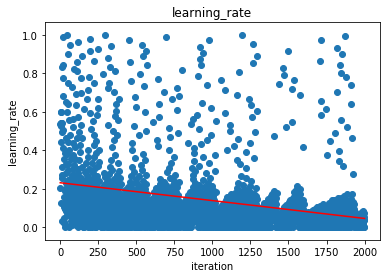

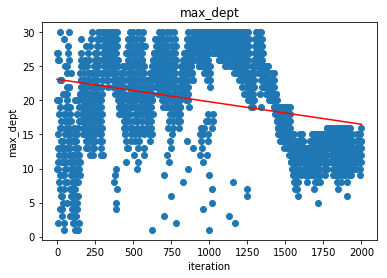

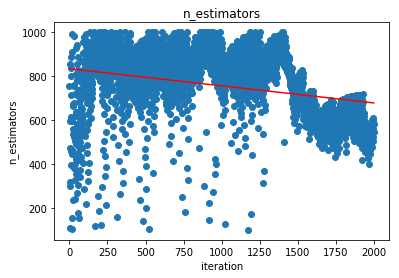

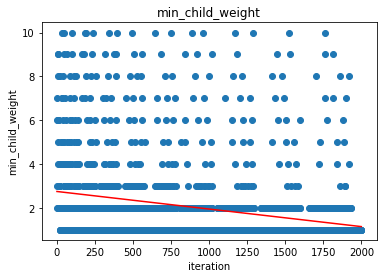

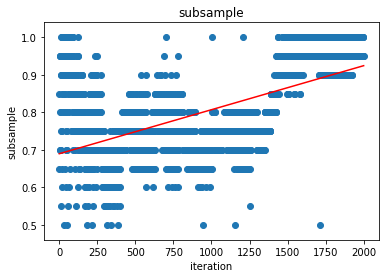

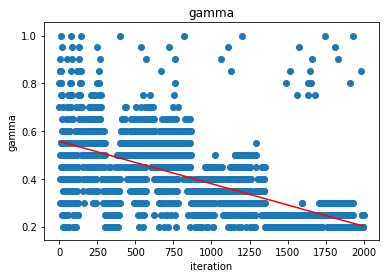

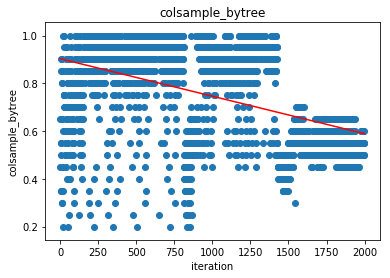

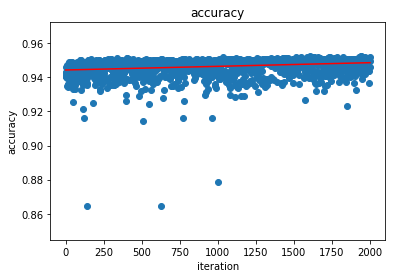

In [34]:
x = np.linspace(0,hyperopt_iterations,hyperopt_iterations)

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"learning_rate"])
plt.title("learning_rate")
plt.xlabel("iteration")
plt.ylabel("learning_rate")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"learning_rate"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"max_dept"])
plt.title("max_dept")
plt.xlabel("iteration")
plt.ylabel("max_dept")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"max_dept"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"n_estimators"])
plt.title("n_estimators")
plt.xlabel("iteration")
plt.ylabel("n_estimators")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"n_estimators"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"min_child_weight"])
plt.title("min_child_weight")
plt.xlabel("iteration")
plt.ylabel("min_child_weight")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"min_child_weight"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"subsample"])
plt.title("subsample")
plt.xlabel("iteration")
plt.ylabel("subsample")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"subsample"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"gamma"])
plt.title("gamma")
plt.xlabel("iteration")
plt.ylabel("gamma")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"gamma"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"colsample_bytree"])
plt.title("colsample_bytree")
plt.xlabel("iteration")
plt.ylabel("colsample_bytree")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"colsample_bytree"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"accuracy"])
plt.title("accuracy")
plt.xlabel("iteration")
plt.ylabel("accuracy")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

# Hyperopt trial value graphs by accuracy

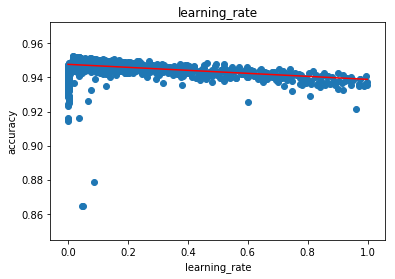

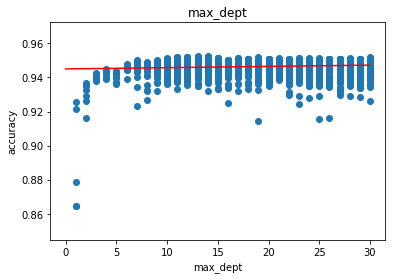

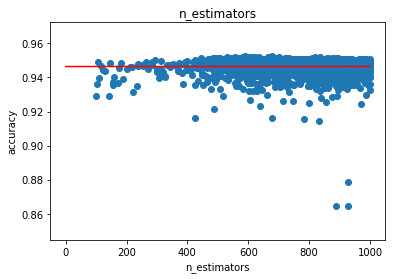

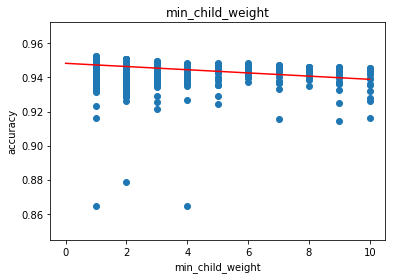

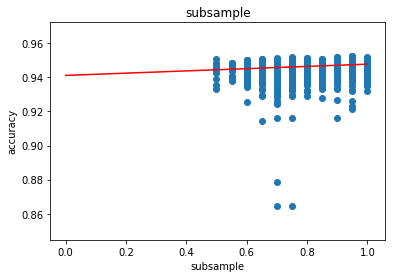

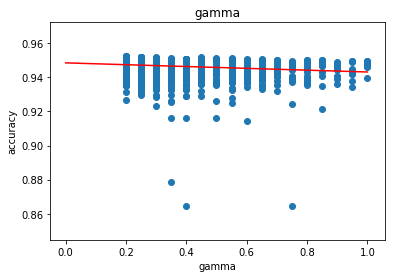

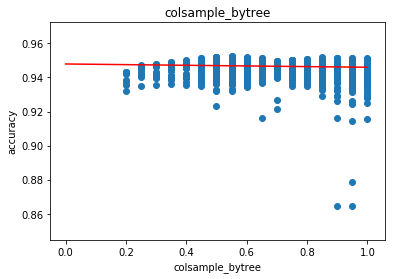

accuracy               0.952639
iteration           1605.000000
learning_rate          0.018000
max_dept              14.000000
n_estimators         678.000000
min_child_weight       1.000000
subsample              0.950000
gamma                  0.200000
colsample_bytree       0.550000
Name: 1605, dtype: float64


In [35]:
plt.scatter(tpe_results.loc[:,"learning_rate"], tpe_results.loc[:,"accuracy"])
plt.title("learning_rate")
plt.ylabel("accuracy")
plt.xlabel("learning_rate")
x = np.linspace(0, tpe_results.loc[:,"learning_rate"].max(),1000)
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"learning_rate"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"max_dept"], tpe_results.loc[:,"accuracy"])
plt.title("max_dept")
plt.ylabel("accuracy")
plt.xlabel("max_dept")
x = np.linspace(0, tpe_results.loc[:,"max_dept"].max(),1000)
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"max_dept"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"n_estimators"], tpe_results.loc[:,"accuracy"])
plt.title("n_estimators")
plt.ylabel("accuracy")
plt.xlabel("n_estimators")
x = np.linspace(0, tpe_results.loc[:,"n_estimators"].max(),1000)
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"n_estimators"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"min_child_weight"], tpe_results.loc[:,"accuracy"])
plt.title("min_child_weight")
plt.ylabel("accuracy")
plt.xlabel("min_child_weight")
x = np.linspace(0, tpe_results.loc[:,"min_child_weight"].max(),1000)
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"min_child_weight"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"subsample"], tpe_results.loc[:,"accuracy"])
plt.title("subsample")
plt.ylabel("accuracy")
plt.xlabel("subsample")
x = np.linspace(0, tpe_results.loc[:,"subsample"].max(),1000)
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"subsample"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"gamma"], tpe_results.loc[:,"accuracy"])
plt.title("gamma")
plt.ylabel("accuracy")
plt.xlabel("gamma")
x = np.linspace(0, tpe_results.loc[:,"gamma"].max(),1000)
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"gamma"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"colsample_bytree"], tpe_results.loc[:,"accuracy"])
plt.title("colsample_bytree")
plt.ylabel("accuracy")
plt.xlabel("colsample_bytree")
x = np.linspace(0, tpe_results.loc[:,"colsample_bytree"].max(),1000)
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"colsample_bytree"], tpe_results.loc[:,"accuracy"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

print(tpe_results.loc[tpe_results["accuracy"].idxmax()])

# Best Params

In [39]:
final_params = copy.deepcopy(best_params)
del final_params["max_dept"]
final_params["max_depth"] = round(best_params["max_dept"])
final_params["n_estimators"] = round(best_params["n_estimators"])

model = xgb.XGBClassifier(**final_params)

score = cross_validate(estimator= model, X = X_test, y = y_test, cv = 10)
avg_score = np.mean(score["test_score"])
train_time = np.mean(score["fit_time"])
test_time = np.mean(score["score_time"])

y_pred = cross_val_predict (model, X_test, y_test, cv = 10)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ("\t True")
print ("\t +\t-")
print ("pred\t+" + str(tp) + "\t" + str(fp))
print ("\t-" + str (fn) + "\t" + str(tn))

print ("PPV:", float(tp)/float(tp + fp))
print ("NPV", float(tn)/float(tn + fn))

print ("Average accuracy: ", avg_score)
print ("Average training time: ", train_time)
print ("Average test time: ", test_time)

#https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    
#find speeding up processing if you can

	 True
	 +	-
pred	+197	45
	-201	2715
PPV: 0.8140495867768595
NPV 0.9310699588477366
Average accuracy:  0.9220986538075145
Average training time:  2.584540772438049
Average test time:  0.023963260650634765


In [17]:
best_params = {'colsample_bytree': 0.55, 'gamma': 0.2, 'learning_rate': 0.018000000000000002, 'max_dept': 14.0, 'min_child_weight': 1.0, 'n_estimators': 678.0, 'subsample': 0.9500000000000001}
final_params = copy.deepcopy(best_params)
del final_params["max_dept"]
final_params["max_depth"] = round(best_params["max_dept"])
final_params["n_estimators"] = round(best_params["n_estimators"])

model = xgb.XGBClassifier(**final_params)

score = cross_validate(estimator= model, X = X_train_sm, y = y_train_sm, cv = 10)
avg_score = np.mean(score["test_score"])
train_time = np.mean(score["fit_time"])
test_time = np.mean(score["score_time"])

y_pred = cross_val_predict (model, X_train_sm, y_train_sm, cv = 10)
tn, fp, fn, tp = confusion_matrix(y_train_sm, y_pred).ravel()
print ("\t True")
print ("\t +\t-")
print ("pred\t+" + str(tp) + "\t" + str(fp))
print ("\t-" + str (fn) + "\t" + str(tn))

print ("PPV:", float(tp)/float(tp + fp))
print ("NPV", float(tn)/float(tn + fn))

print ("Average accuracy: ", avg_score)
print ("Average training time: ", train_time)
print ("Average test time: ", test_time)

C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

	 True
	 +	-
pred	+5957	178
	-451	6230
PPV: 0.9709861450692746
NPV 0.9324951354587636
Average accuracy:  0.9509304309672387
Average training time:  14.49569730758667
Average test time:  0.15740678310394288
